# Imports libraries and data

In [15]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import mritopng
from PIL import Image

import torch

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.models.vgg import vgg19
import sys
sys.path.append('./Zero-Learning-Fast-Medical-Image-Fusion')
from utils import *

import shutil
import tensorflow as tf

current_path = os.getcwd()
data_path = os.path.join(current_path, 'Data\manifest-MjbMt99Q1553106146386120388')
metadata_path = os.path.join(data_path, 'metadata.csv')
info_path = os.path.join(data_path, 'INFOclinical_STS_csv.csv')
# import data
metadata = pd.read_csv(metadata_path)
info = pd.read_csv(info_path)

# EDA and Metadata Pre-proccessing Before Image Pre-proccessing

In [16]:
info.head()

,Subject ID,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days)
0,STS_001,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets - arms,266,D,845
1,STS_002,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501
2,STS_003,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756
3,STS_004,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792
4,STS_005,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647


In [17]:
metadata.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT1,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.05 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:17.081
1,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T1 - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,21.06 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:18.905
2,1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT2FS,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,793.95 KB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:20.531
3,1.3.6.1.4.1.14519.5.2.1.5168.1900.267475167888...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T2 FAT SAT - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,11.89 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:22.271
4,1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,RTstructAlignedT1toPET,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.22 MB,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,2022-12-04T15:17:22.541


## Check how many images per modality

,Number of Images
Modality,
CT,13607
MR,10753
PT,13617
RTSTRUCT,306


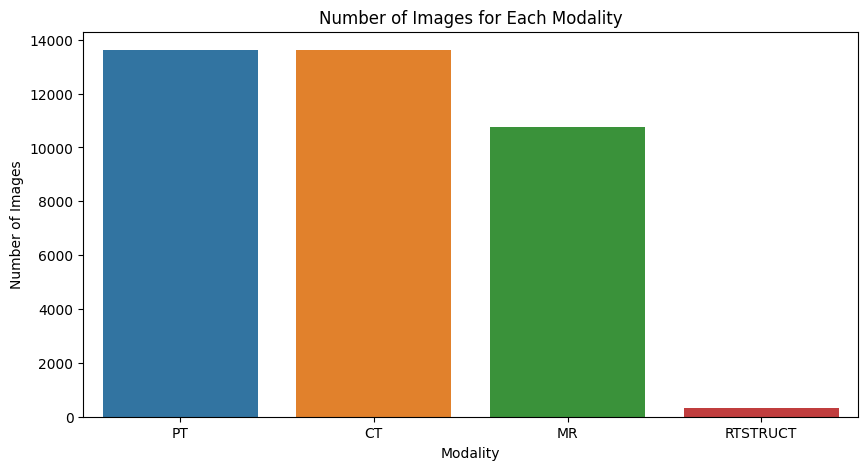

In [18]:
display(metadata[['Number of Images','Modality']].groupby('Modality').sum())
# plot the sum number of images for each modality in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='Modality', 
            y='Number of Images', 
            data=metadata[['Number of Images','Modality']]
            .groupby('Modality')
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.title('Number of Images for Each Modality')
plt.show()

## Check how many subjects per MSKCC type

,Subject ID
MSKCC type,
Extraskeletal bone sarcoma,4
Fibrosarcoma,1
Leiomyosarcoma,10
Liposarcoma,11
MFH,17
Other,3
Synovial sarcoma,5


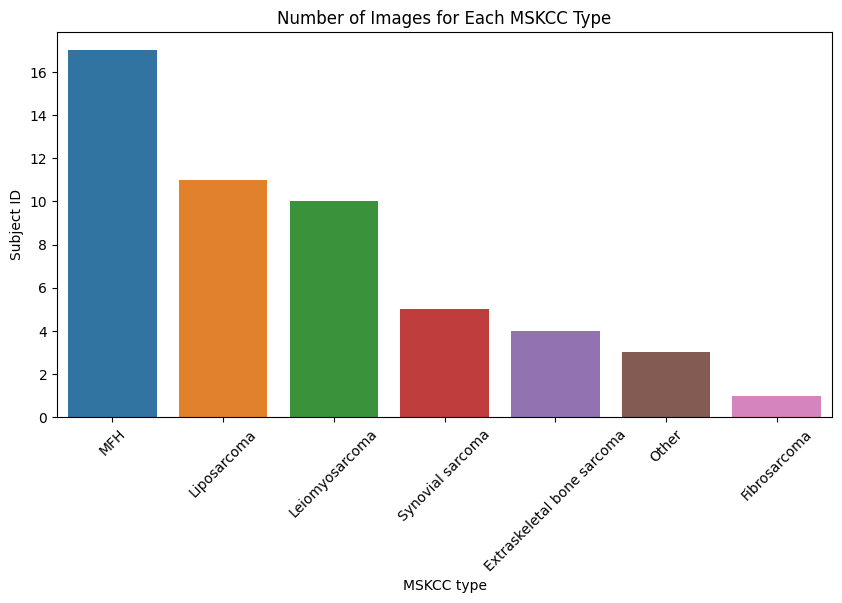

In [19]:
display(info[['Subject ID','MSKCC type']].groupby('MSKCC type').count())
# plot the number of images for each MSKCC type in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Subject ID',
            data=info[['Subject ID','MSKCC type']]
            .groupby('MSKCC type')
            .count()
            .reset_index()
            .sort_values('Subject ID', ascending=False),)
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type')
plt.show()

## Extract relevant columns from both metadataset and join them

In [20]:
meta_extracted = metadata[['Subject ID','Modality','Number of Images', 'File Location','Series Description']]
info_extracted = info[['Subject ID','MSKCC type']]

In [21]:
# join two dataframes
meta_info_join = pd.merge(meta_extracted, info_extracted, on='Subject ID', how='left')

In [22]:
meta_info_join

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT1,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
2,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT2FS,Liposarcoma
3,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
4,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,RTstructAlignedT1toPET,Liposarcoma
...,...,...,...,...,...,...
607,STS_051,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,RTstructPET,Synovial sarcoma
608,STS_051,CT,267,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,CT IMAGES - LEGS - RESEARCH,Synovial sarcoma
609,STS_051,MR,50,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT1toPETBOX,Synovial sarcoma
610,STS_051,MR,52,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT2FStoPETBOX,Synovial sarcoma


## Extract MRI images and non-PETBOX images

In [23]:
# check MR images
meta_info_extracted = meta_info_join[(meta_info_join['Modality'] == 'MR') & (meta_info_join['Series Description'].str.contains('PETBOX') != True)].reset_index(drop=True)
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other
...,...,...,...,...,...,...
97,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma
99,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma
100,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma


## Add PNG File Location to the metadataset

In [24]:
#  png files location
file_location = meta_info_extracted['File Location'].tolist()
# add png infront of the file location
new_file_location = [x[:21] + '-png' + x[21:] for x in file_location]
meta_info_extracted['PNG File Location'] = new_file_location

## Get rid of STS_029 due to non-matching images

In [25]:
# Get rid of STS_029 due to non-matching images
meta_info_extracted = meta_info_extracted[meta_info_extracted['Subject ID'] != 'STS_029']

In [26]:
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other,.\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...
...,...,...,...,...,...,...,...
97,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...
99,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...
100,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


## Check the number of images per each MSKCC type and modality

Number of Images
Modality MSKCC type                                  
MR       MFH                                     1106
         Liposarcoma                              850
         Leiomyosarcoma                           733
         Synovial sarcoma                         342
         Extraskeletal bone sarcoma               284
         Other                                    176
         Fibrosarcoma                             100

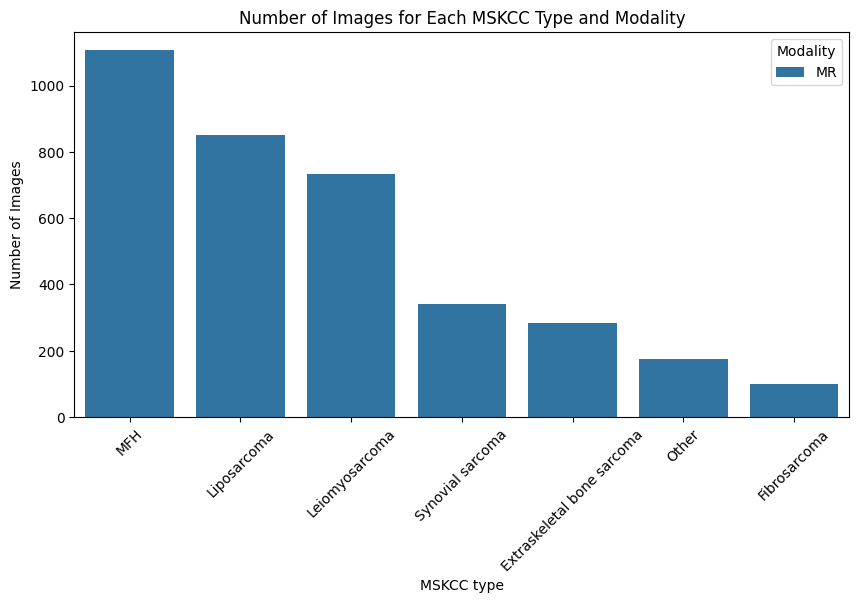

In [27]:
display(meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
 .groupby(['Modality', 'MSKCC type'])
 .sum()
 .sort_values('Number of Images', ascending=False))
#  plot 
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Number of Images',
            hue='Modality',
            data=meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
            .groupby(['Modality', 'MSKCC type'])
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type and Modality')
plt.show()

## Checkpoint creation #1

In [40]:
# Checkpoint 1: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-1.csv', index=False)

# Image Pre-proccessing

## Resume from checkpoint #1

In [42]:
# Restore checkpoint 1
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-1.csv')

## Convert dicom to png

In [43]:
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other,.\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...
...,...,...,...,...,...,...,...
95,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...
96,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...
97,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


In [44]:
for i in range(len(meta_info_extracted)):
    try:
        mritopng.convert_folder(os.path.join(data_path, meta_info_extracted['File Location'].iloc[i])
                                , os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i]))
    except:
        print(meta_info_extracted['File Location'].iloc[i], 'already converted')

.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\11.000000-AXIAL SE T1 - RESEARCH-12555 already converted
.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\10.000000-AXIAL SE T2 FAT SAT - RESEARCH-62438 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\501.000000-AXT1-02298 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\701.000000-STIR longTE AX-10990 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\4.000000-AX STIR-73168 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\5.000000-AX T1-51267 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\501.000000-T2ST RT - RESEARCH-20620 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\601.000000-T1 RT - RESEARCH-86077 already converted
.\Soft-tissue-Sarcoma\STS_005\05-29-2005-NA-IRM BRAS GAUCHE C-C-94418\3.000000-AXIALT1-40756 already converted
.\S

## Add Parent Directory to the metadataset

In [45]:
#  save original path
original_path = os.getcwd()

#  add a column that contain the parent directory
meta_info_extracted['Parent Directory'] = meta_info_extracted['PNG File Location'].apply(lambda x: os.path.join(data_path, x))
for i in range(len(meta_info_extracted)):
    #  move up one directory
    os.chdir(meta_info_extracted['Parent Directory'].iloc[i])
    os.chdir('..')
    #  record the child directory into the column
    parent_directory = os.getcwd()
    rel_parent_directory = os.path.relpath(parent_directory, start=data_path)
    meta_info_extracted['Parent Directory'].iloc[i] = ".\\" + rel_parent_directory

#  move back to original directory
os.chdir(original_path)

## M - Cleaned the pictures manually due to extra images that can impact image fusing

## Update file name and remove orignal file column

In [46]:
#  change the word Soft-tissue-Sarcoma-png to Soft-tissue-Sarcoma-png - Manual Cleaning
meta_info_extracted['PNG File Location'] = meta_info_extracted['PNG File Location'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
meta_info_extracted['Parent Directory'] = meta_info_extracted['Parent Directory'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
# remove image file column
meta_info_extracted = meta_info_extracted.drop(columns=['File Location'])

## Update image number

In [47]:
# join png file location with data directory and update number of images based on png files
meta_info_extracted['Number of Images'] = (meta_info_extracted['PNG File Location']
                                      .apply(lambda x: os.path.join(data_path, x))
                                      .apply(lambda x: len(os.listdir(x))))

In [48]:
meta_info_extracted

,Subject ID,Modality,Number of Images,Series Description,MSKCC type,PNG File Location,Parent Directory
0,STS_001,MR,40,AXIAL SE T1 - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...
1,STS_001,MR,40,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...
2,STS_002,MR,15,AXT1,Leiomyosarcoma,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...
3,STS_002,MR,15,STIR longTE AX,Leiomyosarcoma,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...
4,STS_003,MR,36,AX STIR,Other,.\STS - Manual Cleaning\STS_003\03-30-2005-NA-...,.\STS - Manual Cleaning\STS_003\03-30-2005-NA-...
...,...,...,...,...,...,...,...
95,STS_049,MR,34,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_049\04-14-2002-NA-...,.\STS - Manual Cleaning\STS_049\04-14-2002-NA-...
96,STS_050,MR,30,AX STIR,Leiomyosarcoma,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...
97,STS_051,MR,48,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\STS - Manual Cleaning\STS_051\10-24-1999-NA-...,.\STS - Manual Cleaning\STS_051\10-24-1999-NA-...
98,STS_050,MR,30,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...


## Checkpoint creation #2

In [49]:
# Checkpoint 2: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-2.csv', index=False)

# Resuming from checkpoint #2

In [ ]:
# Restore checkpoint 2
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-2.csv')

## Resizing images

In [51]:
#  for each image in the png file location, resize to 224x224
for i in range(len(meta_info_extracted)):
    # png file location
    png_file_location = os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i])
    image_list = os.listdir(png_file_location)
    for image in image_list:
        #  open image
        im = Image.open(os.path.join(png_file_location, image))
        #  resize image
        im = im.resize((224, 224))
        #  save image
        im.save(os.path.join(png_file_location, image))

## Fuse images

In [52]:
# pretrained model
def fuse_images(image_1_path, image_2_path, output_path):
    def imread(image, mode):
        return np.array(Image.open(image).convert(mode))
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
    model = vgg19(pretrained=True)
    vgg19_relus = [1, 3, 8]

    # path_to_images = ['images/IV_images/1-38.dcm.png', 'images/IV_images/1-38.dcm - Copy.png']
    path_to_images = [image_1_path, image_2_path]

    imgs = [imread(p, mode='L') for p in path_to_images]

    float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
    bases, details = decompose(float_imgs)

    Wb_0 = sal_weights(imgs)
    Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
    Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

    fused_base = weighted_sum(bases, Wb)

    tc_details = stack_to_tensor(details)
    fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

    fused = np.clip(fused_base + fused_detial, 0, 1)
    fused = np.rint(fused * 255).astype(np.uint8)
    
    # save image in output path
    im = Image.fromarray(fused)
    im.save(output_path)

In [55]:
# create fuse column and have everything as false
meta_info_extracted['Fuse'] = False
while False in meta_info_extracted['Fuse'].tolist():
    #  check for the first row that is not fused
    first_fuse_row = meta_info_extracted[meta_info_extracted['Fuse'] == False].iloc[0]
    #  check for the rows that has the same parent directory and different png file location
    try:
        second_fuse_row = meta_info_extracted[(meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'])
                                         & (meta_info_extracted['PNG File Location'] != first_fuse_row['PNG File Location'])].iloc[0]
        if second_fuse_row.empty:
            raise Exception('Fuse Rows not found')
    except Exception as e:
        print(str(e))
    
    # fusing operations -------------------------------------------------------------------
    # list of images in the first row
    first_row_images = os.listdir(os.path.join(data_path, first_fuse_row['PNG File Location'][2:]))
    # list of images in the second row
    second_row_images = os.listdir(os.path.join(data_path, second_fuse_row['PNG File Location'][2:]))
    # make directory for fused images
    os.makedirs(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused'), exist_ok=True)
    for image_index in range(len(first_row_images)):
        image_number = image_index + 1
        image_number = str(image_number).zfill(3)
        fuse_image_name = 'fused-' + image_number + '.png'
        #  fuse the images
        if os.path.exists(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index])) and os.path.exists(os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index])):
            # if the fused image does not exist
            if not os.path.exists(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name)):
                fuse_images(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index]),
                            os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index]),
                            os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name))
    # end of fusing operations ------------------------------------------------------------
    
    #  change fuse to true for every parent directory that has the same parent directory
    meta_info_extracted.loc[meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'], 'Fuse'] = True

#  remove fuse column
meta_info_extracted = meta_info_extracted.drop('Fuse', axis=1)

In [56]:
#  create a new dataframe that contains the parent directory of the fused images
meta_info_fused = meta_info_extracted.drop_duplicates(subset=['Parent Directory'])

meta_info_fused.drop(['PNG File Location', 'Modality'], axis=1, inplace=True)
#  add fused after the parent direcotry
meta_info_fused['Parent Directory'] = meta_info_fused['Parent Directory'] + '\\fused'
# rename parent directory to fused image directory
meta_info_fused.rename(columns={'Parent Directory': 'Fused Image Directory'}, inplace=True)
# update image count based on the number of images in the fused image directory
try:
    for i in range(len(meta_info_fused)):
        meta_info_fused['Number of Images'].iloc[i] = len(os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:])))
except:
    print('Error in updating image count')

## Checkpoint creation #3

In [58]:
#check point 3
meta_info_fused.to_csv( 'csv_checkpoints\\meta_info_fused-3.csv', index=False)

## Resuming from checkpoint #3

In [61]:
# resume from check point 3
meta_info_fused = pd.read_csv('csv_checkpoints\\meta_info_fused-3.csv')

## Number of Images in each MSKCC type after fusing

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,88
Fibrosarcoma,50


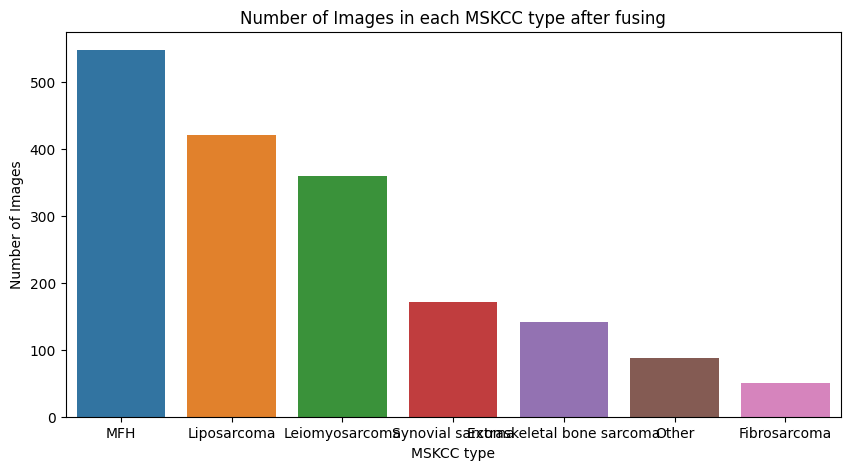

In [69]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()